<a href="https://colab.research.google.com/github/chongzicbo/Dive-into-Deep-Learning-tf.keras/blob/master/9.1.%20%E5%9B%BE%E5%83%8F%E5%A2%9E%E5%B9%BF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##9.1. 图像增广
在“深度卷积神经网络（AlexNet）”小节里我们提到过，大规模数据集是成功应用深度神经网络的前提。图像增广（image augmentation）技术通过对训练图像做一系列随机改变，来产生相似但又不同的训练样本，从而扩大训练数据集的规模。图像增广的另一种解释是，随机改变训练样本可以降低模型对某些属性的依赖，从而提高模型的泛化能力。例如，我们可以对图像进行不同方式的裁剪，使感兴趣的物体出现在不同位置，从而减轻模型对物体出现位置的依赖性。我们也可以调整亮度、色彩等因素来降低模型对色彩的敏感度。可以说，在当年AlexNet的成功中，图像增广技术功不可没。本节我们将讨论这个在计算机视觉里被广泛使用的技术。

首先，导入实验所需的包或模块。

In [0]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import losses,optimizers,Sequential,layers
from tensorflow.data import Dataset
from IPython import display
from matplotlib import pyplot as plt
import cv2
import sys
import time
from tensorflow.keras.applications import vgg16

In [0]:
tf.enable_eager_execution()

###9.1.1. 常用的图像增广方法
我们来读取一张形状为400×500（高和宽分别为400像素和500像素）的图像作为实验的样例。

In [0]:
def use_svg_display():
  #用矢量图显示
  display.set_matplotlib_formats('svg')
def set_figsize(figsize=(3.5,2.5)):
  use_svg_display()
  #设置图的尺寸
  plt.rcParams['figure.figsize']=figsize

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


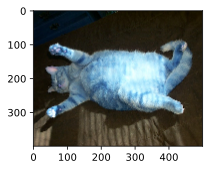

In [6]:
set_figsize()
img=cv2.imread('/content/drive/My Drive/data/d2l-zh-tensoflow/img/cat1.jpg')
plt.imshow(img)

In [0]:
def show_images(imgs,num_rows,num_cols,scale=2):
  figsize=(num_cols*scale,num_rows*scale)
  _,axes=plt.subplots(num_rows,num_cols,figsize=figsize)
  for i in range(num_rows):
    for j in range(num_cols):
      axes[i][j].imshow(imgs[i*num_cols+j].numpy()/255)
      axes[i][j].axes.get_xaxis().set_visible(False)
      axes[i][j].axes.get_yaxis().set_visible(False)
  return axes

大部分图像增广方法都有一定的随机性。为了方便观察图像增广的效果，接下来我们定义一个辅助函数apply。这个函数对输入图像img多次运行图像增广方法aug并展示所有的结果。

In [0]:
def apply(img,aug,num_rows=2,num_cols=4,scale=1.5):
  Y=[aug(img) for _ in range(num_rows*num_cols)]
  show_images(Y,num_rows,num_cols,scale)

####9.1.1.1. 翻转和裁剪
左右翻转图像通常不改变物体的类别。它是最早也是最广泛使用的一种图像增广方法。下面我们通过tf.image模块的flip_left_right方法来实现图像左右翻转。

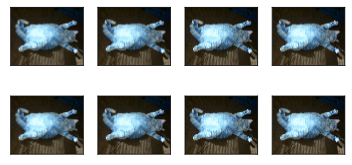

In [9]:
apply(img,tf.image.flip_left_right)

上下翻转不如左右翻转通用。但是至少对于样例图像，上下翻转不会造成识别障碍。下面我们使用flip_up_down方法来实现图像上下翻转。

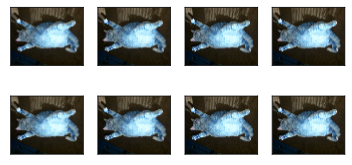

In [10]:
apply(img,tf.image.flip_up_down)

在我们使用的样例图像里，猫在图像正中间，但一般情况下可能不是这样。在“池化层”一节里我们解释了池化层能降低卷积层对目标位置的敏感度。除此之外，我们还可以通过对图像随机裁剪来让物体以不同的比例出现在图像的不同位置，这同样能够降低模型对目标位置的敏感性。\
下面的代码里，使用resize_images方法和random_crop来实现图像的随机裁剪和缩放

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f040e35ab70>,
      dtype=object)

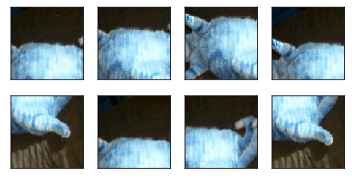

In [11]:
#随机裁剪并resize
num_rows=2
num_cols=4
scale=1.5
shape=img.shape
height=shape[0]//2
width=shape[1]//2
channels=shape[2]
Y=[tf.image.resize_images(tf.image.random_crop(img,[height,width,channels]),size=(100,100)) for _ in range(num_rows*num_cols)]
show_images(Y,num_rows,num_cols,scale)

####9.1.1.2. 变化颜色
另一类增广方法是变化颜色。我们可以从4个方面改变图像的颜色：亮度、对比度、饱和度和色调。在下面的例子里，我们将调整图像的亮度

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f040e35a860>,
      dtype=object)

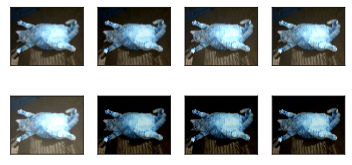

In [12]:
#随机调整图片亮度
Y=[tf.image.random_brightness(img,max_delta=0.2) for _ in range(num_rows*num_cols)]
show_images(Y,num_rows,num_cols,scale)

类似地，我们也可以变化图像的色调

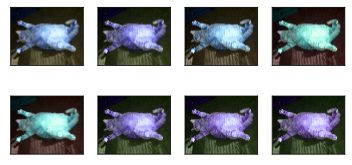

In [13]:
#随机变化图像的色调
Y=[tf.image.random_hue(img,max_delta=0.2) for _ in range(num_rows*num_cols)]
axes=show_images(Y,num_rows,num_cols,scale)

###9.1.2. 使用图像增广训练模型
下面我们来看一个将图像增广应用在实际训练中的例子。这里我们使用CIFAR-10数据集，而不是之前我们一直使用的Fashion-MNIST数据集。这是因为Fashion-MNIST数据集中物体的位置和尺寸都已经经过归一化处理，而CIFAR-10数据集中物体的颜色和大小区别更加显著。下面展示了CIFAR-10数据集中前32张训练图像。

In [14]:
(x_train,y_train),(x_test,y_test)=keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


In [15]:
x_train.shape,y_train.shape

((50000, 32, 32, 3), (50000, 1))

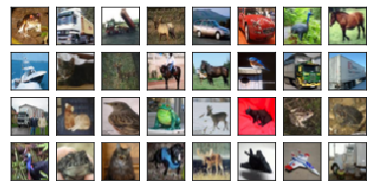

In [16]:
axes=show_images(tf.constant(x_train[0:32]),4,8,scale=0.8)

为了在预测时得到确定的结果，我们通常只将图像增广应用在训练样本上，而不在预测时使用含随机操作的图像增广。在这里我们只使用最简单的随机左右翻转，并将图像像素值变换为在0到1之间且类型为32位浮点数。

In [0]:
train_dataset=Dataset.from_tensor_slices((x_train,y_train)).shuffle(10000).map(lambda x,y:(x/255,y)).batch(256).map(lambda x,y:(tf.image.random_flip_left_right(x),y)) #训练数据
test_dataset=Dataset.from_tensor_slices((x_test,y_test)).map(lambda x,y:(x/255,y)).batch(256) #训练数据

In [18]:
for x,y in train_dataset:
  # print(x.shape,y.shape)
  print(x.shape)
  print(y[0].shape)
  break

(256, 32, 32, 3)
(1,)


9.1.2.1.训练模型
下面使用随机左右翻转的图像增广来训练模型

In [0]:
optimizer=optimizers.Adam() #优化器
loss=losses.SparseCategoricalCrossentropy(from_logits=True) #损失函数

我们构建一个简单的卷积神经网络来训练

In [0]:
net=keras.Sequential([
  layers.Conv2D(filters=32,kernel_size=3,strides=1,padding='same',activation='relu'),
  layers.Conv2D(filters=32,kernel_size=3,strides=1,padding='same',activation='relu'),
  layers.MaxPool2D(pool_size=(2,2)),  
  layers.Conv2D(filters=64,kernel_size=3,strides=1,padding='same',activation='relu'),
  layers.Conv2D(filters=64,kernel_size=3,strides=1,padding='same',activation='relu'),
  layers.MaxPool2D(pool_size=(2,2)), 
  layers.Flatten(),
  layers.Dense(512),
  layers.Dropout(0.4),
  layers.Dense(10,activation='softmax'),                    
])

In [21]:
net.compile(optimizer=optimizer,loss=loss,metrics=['accuracy'])
net.fit_generator(train_dataset,validation_data=test_dataset,epochs=30)

Epoch 1/30
196/196 [==============================] - 13s 66ms/step - loss: 2.0988 - acc: 0.2899 - val_loss: 2.0051 - val_acc: 0.4589
Epoch 2/30
196/196 [==============================] - 9s 47ms/step - loss: 1.9939 - acc: 0.4525 - val_loss: 1.9780 - val_acc: 0.4794
Epoch 3/30
196/196 [==============================] - 9s 47ms/step - loss: 1.9315 - acc: 0.5116 - val_loss: 1.9062 - val_acc: 0.5513
Epoch 4/30
196/196 [==============================] - 9s 48ms/step - loss: 1.8736 - acc: 0.5709 - val_loss: 1.8462 - val_acc: 0.6137
Epoch 5/30
196/196 [==============================] - 9s 47ms/step - loss: 1.8230 - acc: 0.6307 - val_loss: 1.8113 - val_acc: 0.6455
Epoch 6/30
196/196 [==============================] - 9s 47ms/step - loss: 1.8042 - acc: 0.6478 - val_loss: 1.7845 - val_acc: 0.6744
Epoch 7/30
196/196 [==============================] - 9s 47ms/step - loss: 1.7835 - acc: 0.6714 - val_loss: 1.7826 - val_acc: 0.6792
Epoch 8/30
196/196 [==============================] - 9s 47ms/step -

9.1.3. 小结
* 图像增广基于现有训练数据生成随机图像从而应对过拟合。
* 为了在预测时得到确定的结果，通常只将图像增广应用在训练样本上，而不在预测时使用含随机操作的图像增广。
* 可以从tf的image模块中获取有关图片增广的方法。